In [1]:
import os
import torchaudio
import torch
import matplotlib.pyplot as plt
from torch.nn import Module, Linear, Sigmoid, LSTM, BCELoss, Conv2d, MaxPool2d, LayerNorm, MultiheadAttention, Dropout
from torch.optim import Adam
import torch.nn.functional as F
from pytorch_model_summary import summary
from tqdm import tqdm
import numpy as np
import math
from torchmetrics import ScaleInvariantSignalNoiseRatio

/home/dfedorovsky/anaconda3/envs/beamformer/lib/python3.9/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [27]:
from DataLoader import DataLoaderAll

X,Y_mask,speech,mix1,X_complex = DataLoaderAll.data_loader(n_noise=100)

# MaskNet + Training

In [3]:
class PositionalEncoding(Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [4]:
# MASK NET
HIDDEN_SIZE=64 # 128
SAMPLE_RATE = 16000
INPUT_CHANNEL = 4 # Always two -> Real and Imaginary part 
D_TF = 1024#1024

class MaskNet(Module):
    def __init__(self,noise=False):
        super(MaskNet, self).__init__()

        self.pe = PositionalEncoding(d_model=196)
        self.ln11 = LayerNorm(normalized_shape=(196))
        self.ln12 = LayerNorm(normalized_shape=(196))
        self.mha1 = MultiheadAttention(embed_dim=196,num_heads=14,dropout=0.1)
        self.lintf1 = Linear(in_features=196,out_features=D_TF)#1024 instead of 256!
        self.lintf12 = Linear(in_features=D_TF,out_features=196)

        self.pe2 = PositionalEncoding(d_model=196)
        self.ln21 = LayerNorm(normalized_shape=(196))
        self.ln22 = LayerNorm(normalized_shape=(196))
        self.mha2 = MultiheadAttention(embed_dim=196,num_heads=14,dropout=0.1)
        self.lintf2 = Linear(in_features=196,out_features=D_TF)#1024 instead of 256!
        self.lintf22 = Linear(in_features=D_TF,out_features=196)

        self.fc = Linear(in_features=4,out_features=1)
        self.sigmoid = Sigmoid()

    def forward(self,x):
        
        x = x.reshape(INPUT_CHANNEL,513,196)

        # Transformer 1
        y = self.pe(x)
        z = self.ln11(y)
        z, _ = self.mha1(z,z,z)
        z_2 = z+y
        z = self.ln12(z_2)
        z = self.lintf1(z)
        z = F.relu(z)
        z = self.lintf12(z)
        x = z+z_2+x

        # Transformer 2
        y = self.pe(x)
        z = self.ln21(y)
        z, _ = self.mha2(z,z,z)
        z_2 = z+y
        z = self.ln22(z_2)
        z = self.lintf2(z)
        z = F.relu(z)
        z = self.lintf22(z)
        x = z+z_2+x
        
        x = x.view(513,196,4)

        x = self.fc(x)
        speech_pred = self.sigmoid(x)
        return speech_pred.reshape(513,-1)#, noise_pred

print(summary(MaskNet(),torch.zeros((513, 196, 4))))

---------------------------------------------------------------------------------------
           Layer (type)                   Output Shape         Param #     Tr. Param #
   PositionalEncoding-1                  [4, 513, 196]               0               0
            LayerNorm-2                  [4, 513, 196]             392             392
   MultiheadAttention-3     [4, 513, 196], [513, 4, 4]         154,448         154,448
            LayerNorm-4                  [4, 513, 196]             392             392
               Linear-5                 [4, 513, 1024]         201,728         201,728
               Linear-6                  [4, 513, 196]         200,900         200,900
            LayerNorm-7                  [4, 513, 196]             392             392
   MultiheadAttention-8     [4, 513, 196], [513, 4, 4]         154,448         154,448
            LayerNorm-9                  [4, 513, 196]             392             392
              Linear-10                 [4

In [76]:
EPOCHS = 30
LEN_TRAIN = 2000
NUM_CHANNEL = 2 # Number of Mic Inputs (>=2 for BF)
REFERENCE_CHANNEL = 0
INIT_LR = 0.0001#0.0001
BATCH_SIZE = 1#64
LEARN_LOSS_PARAMS = False
device =  torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

model = MaskNet().to(device)
model= torch.nn.DataParallel(model,device_ids=[0])

#lossBCE = BCELoss()
lossSiSNR = ScaleInvariantSignalNoiseRatio().to(device)

opt = Adam(model.parameters(), lr=INIT_LR)
lambda1 = lambda epoch: 0.65 ** epoch
#lr_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=opt, lr_lambda=lambda1)

H = {
    "train_loss":[],
    "train_acc":[],
    "val_loss":[],
    "val_acc":[]
}

def check_accuracy_validation(model):
    example_nr = int(np.random.random()*(len(X)-LEN_TRAIN)+LEN_TRAIN)
    model.eval()
    pred = maskToWave(model(X[example_nr]),example_nr)
    val_loss = lossSiSNR(pred,Y[example_nr][0])
    model.train()
    return val_loss

istft = torchaudio.transforms.InverseSpectrogram(n_fft=1024, hop_length=256).to(device)
def maskToWave(speech_pred,i):
        #speech_pred = (speech_pred>0.2).float()
        noise_pred = torch.ones([513,speech_pred.shape[1]]).to(device)-speech_pred
        psd_transform = torchaudio.transforms.PSD()
        psd_speech = psd_transform(X_complex[i], speech_pred)
        psd_noise = psd_transform(X_complex[i], noise_pred)
        mvdr_transform = torchaudio.transforms.SoudenMVDR()
        stft_souden = mvdr_transform(X_complex[i], psd_speech, psd_noise, reference_channel=0)
        waveform_souden = istft(stft_souden, length=len(speech[i][0]))#X[i].shape[-1])
        return waveform_souden.reshape(-1)


print("[INFO] training the network...")
#X = stft_mix[:50].to(device)
#Y = Y.to(device)
X = X.to(device)
Y = speech.to(device)
X_complex = X_complex.to(device)
trainX = X[:LEN_TRAIN]
trainY = Y

for epoch in range(0, EPOCHS):
    print("Epoch:",str(epoch+1)+"/"+str(EPOCHS))
    # Train Mode
    model.train()
    
    # Initialize
    totalTrainLoss = 0
    totalValLoss = 0
    trainCorrect = 0
    valCorrect = 0

    for i in tqdm(range(0,len(trainX))): # Iterate over Training Examples
        y_s = trainY[i][0] # 0 speech only
        x = trainX[i]
        try:
            speech_pred=maskToWave(model(x),i)
        except Exception:
            continue
        loss = -lossSiSNR(speech_pred,y_s)
        # zero out the gradients, perform the backpropagation step, and update the weights
        opt.zero_grad()
        loss.backward()
        opt.step()
        #H["train_acc"].append(check_accuracy_training(speech_pred,y_s))
        H["train_loss"].append(float(loss))
        if i % 10 == 0:
            val_loss = check_accuracy_validation(model)
            #H["val_acc"].append(val_acc)
            H["val_loss"].append(float(val_loss))
    # Print results of Epoch        
    #print("Average Training Accuracy in Epoch",str(epoch+1),":",np.mean(np.array(H["train_acc"])))
    print("Average Training Loss in Epoch",str(epoch+1),":",(-sum(H["train_loss"][-2000:]))/2000)
    #print("Average Validation Accuracy in Epoch",str(epoch+1),":",np.mean(np.array(H["val_acc"])))
    print("Total Validation Loss in Epoch",str(epoch+1),":",(sum(H["val_loss"][-10:]))/10)
    # Save Model after Epoch        
    MODEL_SAVE_PATH = '/project/data_asr/CHiME5/data/librenoise/models/TFall'
    torch.save(model.state_dict(), MODEL_SAVE_PATH + "epoch" + str(epoch+1) + ".pt")
    #if epoch >= 5:
    #    if sum(H["val_loss"][-10:])/10 < sum(H["val_loss"][-20:-10])/10 and sum(H["val_loss"][-10:])/10 < sum(H["val_loss"][-30:-20])/10:
    #lr_scheduler.step()
    print(totalTrainLoss)

[INFO] training the network...
Epoch: 1/30


 13%|█▎        | 254/2000 [00:03<00:25, 68.11it/s]


KeyboardInterrupt: 

## Load Model & Evaluate

In [72]:
PATH = MODEL_SAVE_PATH = "/project/data_asr/CHiME5/data/librenoise/models/TFallepoch30.pt"
#device = torch.device('cuda:0')
state_dict = torch.load(PATH)
# create new OrderedDict that does not contain `module.`
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k[7:] # remove `module.` from state dict
    new_state_dict[name] = v
# load params
model = MaskNet()
model.load_state_dict(new_state_dict)
#model= torch.nn.DataParallel(model)
#model.load_state_dict(torch.load(PATH))#,map_location=device))
#model.to(device)
model.eval()

MaskNet(
  (pe): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (ln11): LayerNorm((196,), eps=1e-05, elementwise_affine=True)
  (ln12): LayerNorm((196,), eps=1e-05, elementwise_affine=True)
  (mha1): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=196, out_features=196, bias=True)
  )
  (lintf1): Linear(in_features=196, out_features=1024, bias=True)
  (lintf12): Linear(in_features=1024, out_features=196, bias=True)
  (pe2): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (ln21): LayerNorm((196,), eps=1e-05, elementwise_affine=True)
  (ln22): LayerNorm((196,), eps=1e-05, elementwise_affine=True)
  (mha2): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=196, out_features=196, bias=True)
  )
  (lintf2): Linear(in_features=196, out_features=1024, bias=True)
  (lintf22): Linear(in_features=1024, out_features=196, bias=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
 

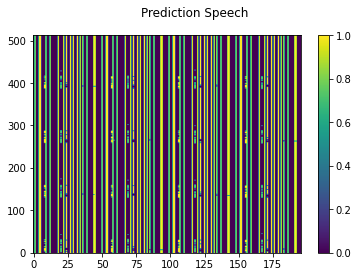

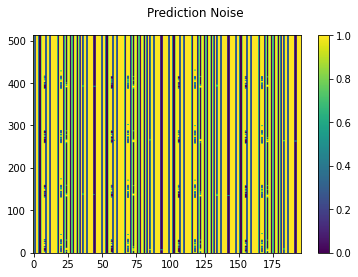

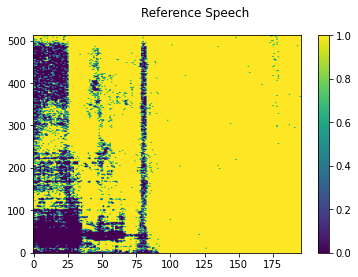

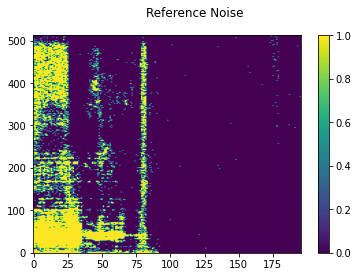

In [73]:
X = X.cpu()
Y = Y.cpu()
def evaluate_example(e_nr):
    model.eval()
    speech_pred = (model(X[e_nr])>0.15).float()
    noise_pred = torch.ones([513,X[e_nr].shape[1]])-speech_pred
    plot_mask(speech_pred, title="Prediction Speech")
    plot_mask(noise_pred, title="Prediction Noise")
    plot_mask(Y_mask[e_nr][0], title="Reference Speech")
    plot_mask(Y_mask[e_nr][1], title="Reference Noise")

def plot_mask(mask, title="Mask", xlim=None):
    mask = mask.detach().numpy()
    figure, axis = plt.subplots(1, 1)
    img = axis.imshow(mask, cmap="viridis", origin="lower", aspect="auto")
    figure.suptitle(title)
    plt.colorbar(img, ax=axis)
    plt.show()

evaluate_example(260)

In [74]:
istft = torchaudio.transforms.InverseSpectrogram(n_fft=1024, hop_length=256)
X_complex = X_complex.cpu()

def si_snr(estimate, reference, epsilon=1e-8):
    estimate = estimate - estimate.mean()
    reference = reference - reference.mean()
    reference_pow = reference.pow(2).mean(axis=1, keepdim=True)
    mix_pow = (estimate * reference).mean(axis=1, keepdim=True)
    scale = mix_pow / (reference_pow + epsilon)

    reference = scale * reference
    error = estimate - reference

    reference_pow = reference.pow(2)
    error_pow = error.pow(2)

    reference_pow = reference_pow.mean(axis=1)
    error_pow = error_pow.mean(axis=1)

    si_snr = 10 * torch.log10(reference_pow) - 10 * torch.log10(error_pow)
    return si_snr.item()

def evaluateSiSNR(wave, i):
    score = si_snr(wave, speech[i])
    #print(f"Si-SNR score: {score}") 
    return score

def maskToWave(speech_pred,noise_pred,mix,i):
        model.eval()
        psd_transform = torchaudio.transforms.PSD()
        psd_speech = psd_transform(mix[i], speech_pred)
        psd_noise = psd_transform(mix[i], noise_pred)
        mvdr_transform = torchaudio.transforms.SoudenMVDR()
        stft_souden = mvdr_transform(mix[i], psd_speech, psd_noise, reference_channel=0)
        waveform_souden = istft(stft_souden, length=len(speech[i][0]))#X[i].shape[-1])
        return waveform_souden.reshape(-1)

def maskToWave(speech_pred,i):
        #speech_pred = (speech_pred>0.2).float()
        noise_pred = torch.ones([513,speech_pred.shape[1]])-speech_pred
        psd_transform = torchaudio.transforms.PSD()
        psd_speech = psd_transform(X_complex[i], speech_pred)
        psd_noise = psd_transform(X_complex[i], noise_pred)
        mvdr_transform = torchaudio.transforms.SoudenMVDR()
        stft_souden = mvdr_transform(X_complex[i], psd_speech, psd_noise, reference_channel=0)
        waveform_souden = istft(stft_souden, length=len(speech[i][0]))#X[i].shape[-1])
        return waveform_souden.reshape(-1)

def save_sample(i,wave,sample_rate=SAMPLE_RATE):
    torchaudio.save("./outputs/sample_reference.wav", speech[i].reshape(1,-1),sample_rate)
    torchaudio.save("./outputs/sample_input.wav", mix1[i].reshape(1,-1),sample_rate)
    torchaudio.save("./outputs/model_out.wav",wave.reshape(1,-1),16000)

index = 2013
speech_pred = (model(X[index])>0.2).float()
#noise_pred = torch.ones([513,speech_pred.shape[1]])-speech_pred
wave = maskToWave(speech_pred,index)#noise_pred,X_complex,index)#X hat nicht mehr nur 2, sondern 4 channel
print(wave.shape)
print(wave)
save_sample(index, wave=wave)
score = evaluateSiSNR(wave,index)#Should be ~28
print(f"Si-SNR score: {score}")

torch.Size([50000])
tensor([ 6.8370e-05,  1.5732e-04, -7.2274e-04,  ..., -3.3873e-03,
        -2.8831e-04,  5.3299e-03])
Si-SNR score: 10.796993255615234


In [75]:
# Test Set
scores = []
for index in range(2000,2703):
    speech_pred = (model(X[index])>0.2).float()
    wave = maskToWave(speech_pred,index)#X hat nicht mehr nur 2, sondern 4 channel
    scores.append(si_snr(wave, speech[index])-si_snr(mix1[index],speech[index]))

np.mean(scores)

-3.8831736427621855